# Initial Set-up

In [1]:
!pip install planarity
import networkx as nx
import planarity

     |████████████████████████████████| 193 kB 4.2 MB/s 
  Created wheel for planarity: filename=planarity-0.4.1-cp37-cp37m-linux_x86_64.whl size=288553 sha256=44932eefd6ca6943ac273458eca60641766d4a0cb59787127cd04fadad97963c
  Stored in directory: /root/.cache/pip/wheels/ae/19/92/2d33078fe3b703cf34dcf6a670652c1d6a58c0a2ebf2b3a68d
Successfully built planarity


In [2]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import time

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Functions Needed

In [127]:
# Correlation matrix and nodes' namelist as input, graph as output
# MST Minimum Spanning Tree
def MST(corr_mat, namelist, draw = False):
  # corr_mat is the correlation matrix as np.array format
  attributes = {}
  for i in range(len(namelist)):
      attributes[i] = namelist[i]

  dist_mx = np.sqrt(2*(1-corr_mat))

  G = nx.from_numpy_matrix(dist_mx)
  MST = nx.minimum_spanning_tree(G,weight='weight')
  nx.set_node_attributes(MST, attributes, name='coin_name')
  # MST is the output minimum spanning tree graph
  if draw == True:
    nx.draw_networkx(MST, pos=None, arrows=None, with_labels=True)
  return MST


# PMFG Planar Maximally Filtered Graph
def PMFG(corr_mat, namelist, draw = False):
  attributes = {}
  for i in range(len(namelist)):
      attributes[i] = namelist[i]

  dist_mx = np.sqrt(2*(1-corr_mat))
  G = nx.from_numpy_matrix(dist_mx)

  def sort_graph_edges(G):
    sorted_edges = []
    for source, dest, data in sorted(G.edges(data=True), key=lambda x: x[2]['weight'], reverse = True): 
        sorted_edges.append({'source': source,
                             'dest': dest,
                             'weight': data['weight']})
    return sorted_edges # a list of dict

  PMFG = nx.Graph()
  ne_total = G.number_of_edges()
  nb_nodes = len(G.nodes)
  ne_pmfg = 3*(nb_nodes-2)
  sorted_edges = sort_graph_edges(G)
  t0 = time.time()
  for i, edge in enumerate(sorted_edges):
      PMFG.add_edge(edge['source'], edge['dest'], weight = edge['weight'])
      if not planarity.is_planar(PMFG):
          PMFG.remove_edge(edge['source'], edge['dest'])
      ne = PMFG.number_of_edges()
      # print("Generating PMFG... added edges in PMFG %d/%d (%.2f%%) lookup edges in G %d/%d (%.2f%%) Elapsed TIme %.2f [sec]"\
      #    %(ne, ne_pmfg, (ne/ne_pmfg)*100, i, ne_total, (i+1/ne_total)*100, time.time()-t0), end="\r")
      if ne == ne_pmfg:
          break
  nx.set_node_attributes(PMFG, attributes, name='coin_name')
  if draw == True:
    nx.draw_networkx(PMFG, pos=None, arrows=None, with_labels=True)
  return PMFG
  

In [128]:
import datetime

def datetime_generator(start,end,interval=1):
  # start,end are date as string format, like '12-04-2021'
  start = datetime.datetime.strptime(start, "%d-%m-%Y")
  end = datetime.datetime.strptime(end, "%d-%m-%Y")
  date_generated = [start + datetime.timedelta(days=x) for x in range(0, (end-start).days,interval)]
  datelist = []
  for date in date_generated:
    datelist.append(date.strftime("%d-%m-%Y"))
  return datelist

In [129]:
def compute_MST_all(Corr_mat,timelist,namelist_all):
  # Input:Corr_mat is the list of corr numpy.ndarrary
  # timelist is the list of time
  # namelist_all is the list of namelist from .json file
  MST_dict = {}
  for i in range(len(Corr_mat)):
    MST_dict[timelist[i]] = MST(Corr_mat[i], namelist_all[i])
  return MST_dict
  #return a dictionary of MST, with keys of date, values of graph

In [87]:
import collections

def sort_NodesDegree(MST_dict,namelist_all):
  # compute the nodes with max average degree
  degree_dict_list = []
  i_g = 0
  for g in MST_dict.values():
    degree_dict = {}
    for n in g.nodes():
      degree_dict[namelist_all[i_g][n]] = g.degree(n)
    degree_dict_list.append(degree_dict)
    i_g += 1
    # got a list of dict, with keys of coin names and values of number of degree 
  counter = collections.Counter()
  for d in degree_dict_list: 
    counter.update(d)
  result = dict(counter)
  sortdict = dict(sorted(result.items(), key=lambda x:x[1],reverse=True))
  return sortdict
  # Got the order of nodes with the most degree in MST

In [84]:
def time_degree(G_dict,coin,namelist_all):
  time_degree = {}
  i = 0
  for g in G_dict.values(): 
    time_degree[list(G_dict.keys())[i]] = g.degree(namelist_all[i].index(coin))
    i += 1
  return time_degree

# Load Data

In [130]:
# Load correlation matrix
Corr_d_04 = np.load('/content/gdrive/MyDrive/Network_Science/Project/cm_data/0412_0615_1d_30m.npy',allow_pickle=True)
Corr_w_04 = np.load('/content/gdrive/MyDrive/Network_Science/Project/cm_data/0412_0615_1W_3h.npy',allow_pickle=True)
Corr_d_08 = np.load('/content/gdrive/MyDrive/Network_Science/Project/cm_data/0816_1018_1d_30m.npy',allow_pickle=True)
Corr_w_08 = np.load('/content/gdrive/MyDrive/Network_Science/Project/cm_data/0816_1018_1W_3h.npy',allow_pickle=True)

In [ ]:
# Load namelist.json
import json
import io
from google.colab import files
uploaded = files.upload()

In [139]:
import json
import io
from google.colab import files
uploaded = files.upload()

Saving 0816_1018_1W_3h_namelist.json to 0816_1018_1W_3h_namelist.json


In [142]:
file_name = "0816_1018_1W_3h_namelist.json"
io.StringIO(uploaded[file_name].decode("utf-8"))

In [135]:
namelist_all_d_04 = json.loads(uploaded[file_name].decode("utf-8"))

In [131]:
namelist_all_w_04 = json.loads(uploaded[file_name].decode("utf-8"))

In [138]:
namelist_all_d_08 = json.loads(uploaded[file_name].decode("utf-8"))

In [143]:
namelist_all_w_08 = json.loads(uploaded[file_name].decode("utf-8"))

# Analysis

From time period 12 Apr.- 15 Jun.

In [145]:
timelist_d_04 = datetime_generator('12-04-2021','15-06-2021',1) # interval is number of days

In [146]:
MST_d_04 = compute_MST_all(Corr_d_04,timelist_d_04,namelist_all_d_04)

In [147]:
print(sort_NodesDegree(MST_d_04,namelist_all_d_04))

{'TRX': 366, 'ETH': 336, 'NEO': 213, 'LINK': 204, 'BTC': 201, 'EOS': 195, 'XTZ': 183, 'BAL': 180, 'LTC': 179, 'SUSHI': 166, 'UNI': 158, 'JST': 157, 'AAVE': 155, 'SNX': 155, 'OMG': 154, 'ADA': 145, 'YFI': 144, 'DOT': 143, 'BAND': 140, 'XRP': 137, 'ZRX': 137, 'BCHN': 129, 'XLM': 127, 'COMP': 127, 'ETC': 123, 'AVAX': 123, 'NEAR': 114, 'KSM': 113, 'ZEC': 107, 'FET': 107, 'BSV': 107, 'FIL': 104, 'SOL': 104, 'XVG': 103, 'SUN': 99, 'EGLD': 99, 'WBT': 97, 'GTX': 97, 'CEL': 95, 'HEZ': 94, 'VET': 94, 'DGB': 93, 'XMR': 91, 'IQX': 90, 'REP': 90, 'BTSE': 90, 'MOB': 89, 'LUNA': 88, 'UOS': 87, 'LEO': 85, 'RBT': 85, 'VSY': 82, 'MLN': 82, 'XAUT': 81, 'BOSON': 80, 'XSN': 80, 'DAI': 79, 'DOGE': 74, 'GNO': 70, 'PNK': 69, 'PLU': 66, 'UOP': 66, 'ETP': 65, 'CLO': 63, 'SAN': 62, 'OXY': 62, 'XDC': 57, 'BFT': 53, 'ZCN': 48, 'XCH': 48, '1INCH': 44, 'ICE': 42, 'CTK': 37, 'BTT': 36, 'IDX': 34, 'ESS': 33, 'B21X': 32, 'DAT': 28, 'BAT': 27, 'OCEAN': 23, 'EUT': 22, 'CHZ': 14, 'KAN': 14, 'BTG': 13, 'XRA': 12, 'RRT': 12

In [150]:
def plot_xy(dict):
  x,y = zip(*dict.items())
  plt.plot(x,y)
  plt.xticks(rotation='vertical')
  plt.show()

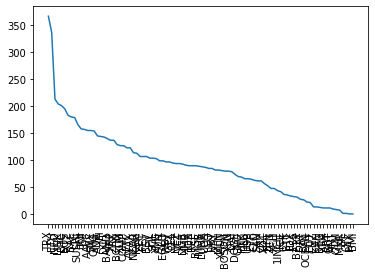

In [151]:
plot_xy(sort_NodesDegree(MST_d_04,namelist_all_d_04))

In [156]:
TRX_degree_d_04 = pd.DataFrame.from_dict(time_degree(MST_d_04,"TRX",namelist_all_d_04),orient='index')

In [158]:
from statsmodels.graphics import tsaplots
import matplotlib.pyplot as plt

#plot autocorrelation function
def plot_acf_coin(coin,MST_dict,namelist_all):
  x = pd.DataFrame.from_dict(time_degree(MST_dict,coin,namelist_all),orient='index')
  fig = tsaplots.plot_acf(x = x[0])
  plt.show()

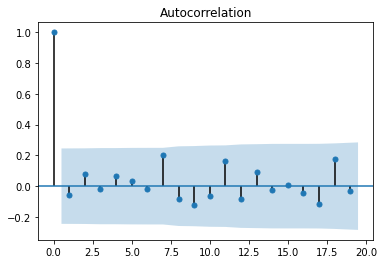

In [161]:
plot_acf_coin('TRX',MST_d_04,namelist_all_d_04)

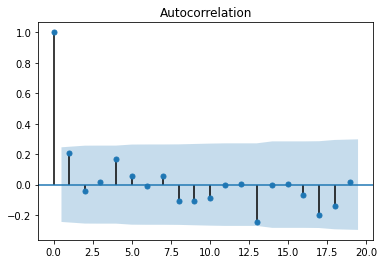

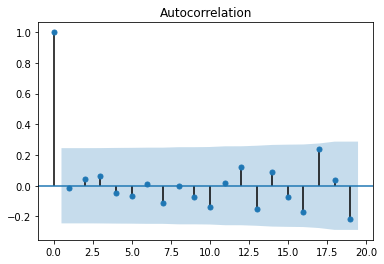

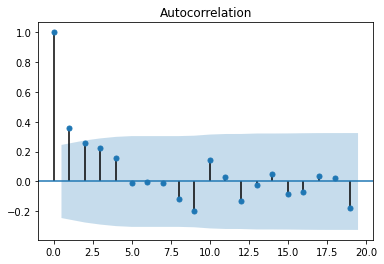

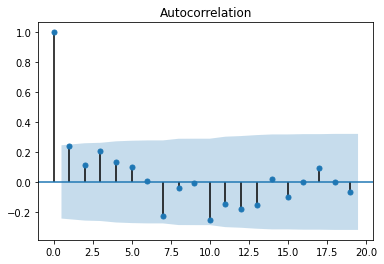

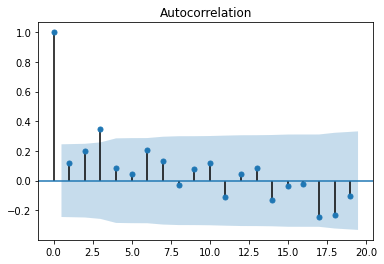

In [164]:
plot_acf_coin('BTC',MST_d_04,namelist_all_d_04)
plot_acf_coin('LINK',MST_d_04,namelist_all_d_04)
plot_acf_coin('ETH',MST_d_04,namelist_all_d_04)
plot_acf_coin('EOS',MST_d_04,namelist_all_d_04)
plot_acf_coin('NEO',MST_d_04,namelist_all_d_04)